---
title: ARIMA and SARIMA models
---

In [137]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA

## co2 dataset (Motivation for Multiplicative Seasonal ARMA models)

Next we study seasonal and multiplicative seasonal ARMA models. The following dataset provides some motivation for considering these models.

     Unnamed: 0       x
0             1  363.05
1             2  364.18
2             3  364.87
3             4  364.47
4             5  364.32
..          ...     ...
127         128  368.69
128         129  368.55
129         130  373.39
130         131  378.49
131         132  381.62

[132 rows x 2 columns]


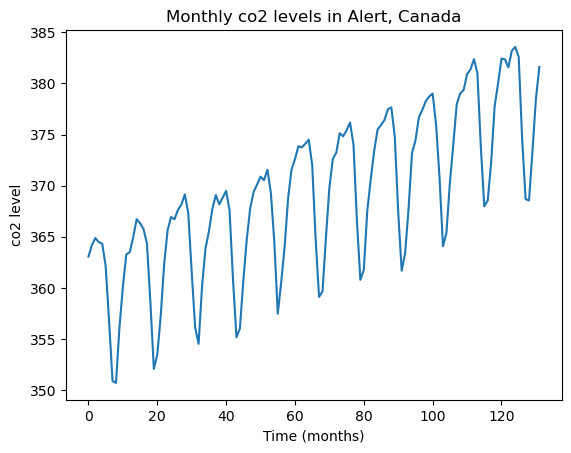

In [138]:
co2 = pd.read_csv('co2_TSA.csv')
print(co2)
#This is a simple time series dataset from the R package TSA 
#TSA is an R package that is written by the authors of the book "Time Series Analysis with Applications in R (second edition)"
#by Jonathan Cryer and Kung-Sik Chan
#This dataset gives the monthly co2 levels in Alert, Canada from January 1994 to December 2004 (132 observations in total for 11 years)
y = co2['x']
#plt.figure(figsize = (12, 7))
plt.plot(y)
plt.xlabel('Time (months)')
plt.ylabel('co2 level')
plt.title('Monthly co2 levels in Alert, Canada')
plt.show()

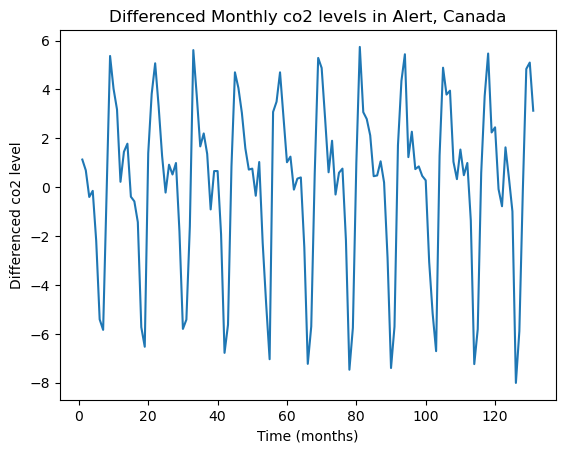

In [139]:
ydiff = y.diff()
plt.plot(ydiff)
plt.xlabel('Time (months)')
plt.ylabel('Differenced co2 level')
plt.title('Differenced Monthly co2 levels in Alert, Canada')
plt.show()

Before fitting stationary ARMA models, we first preprocess the data by differencing. We first take the seasonal difference: $\nabla_s y_t = y_t - y_{t-s}$ where $s = 12$. 

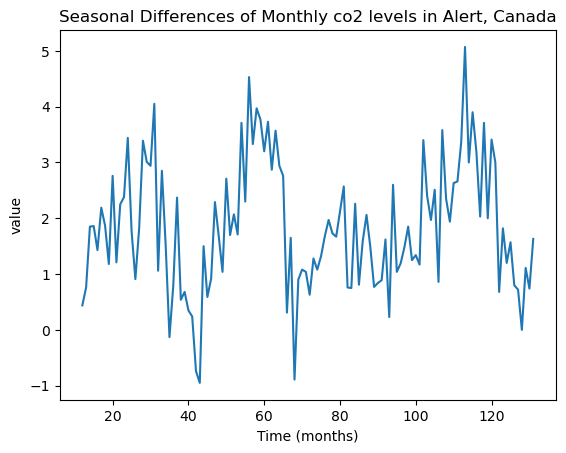

In [140]:
#Seasonal differencing: y_t - y_{t-12}
ydiff12 = y.diff(periods = 12) #this works when y is a pandas series (it will not work when y is a np array for example)
#plt.figure(figsize = (12, 7))
plt.plot(ydiff12)
plt.xlabel('Time (months)')
plt.ylabel('value')
plt.title('Seasonal Differences of Monthly co2 levels in Alert, Canada')
plt.show()


Note that there will be NAs corresponding to the first 12 observations. The presence of these NAs might cause issues with subsequent functions (such as plot_acf and plot_pacf). 

In [141]:
#there will be NAs in the first twelve entries of ydiff12
print(ydiff12)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
127    0.72
128    0.00
129    1.11
130    0.74
131    1.63
Name: x, Length: 132, dtype: float64


Below we use '.dropna()' to remove NAs before plotting ACF and PACF. 

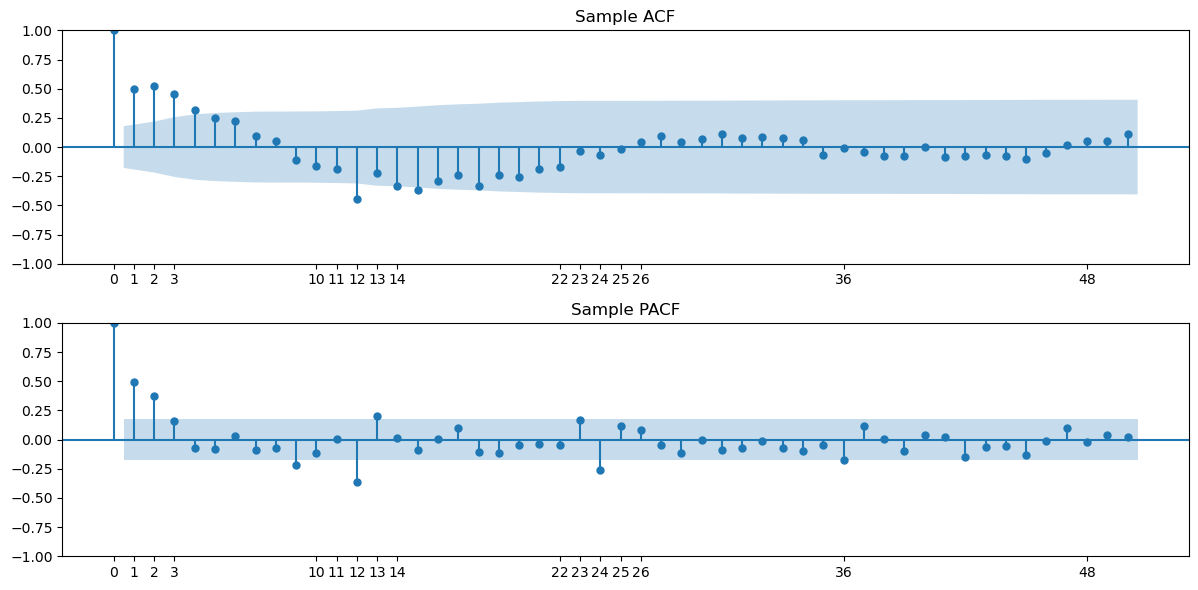

In [142]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(ydiff12.dropna(), lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
axes[0].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plot_pacf(ydiff12.dropna(), lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
axes[1].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plt.tight_layout()
plt.show()

Based on the plot of $\nabla_s y_t$, it appear that there are still some trends in the dataset. So we difference one more time before fitting stationary models. 

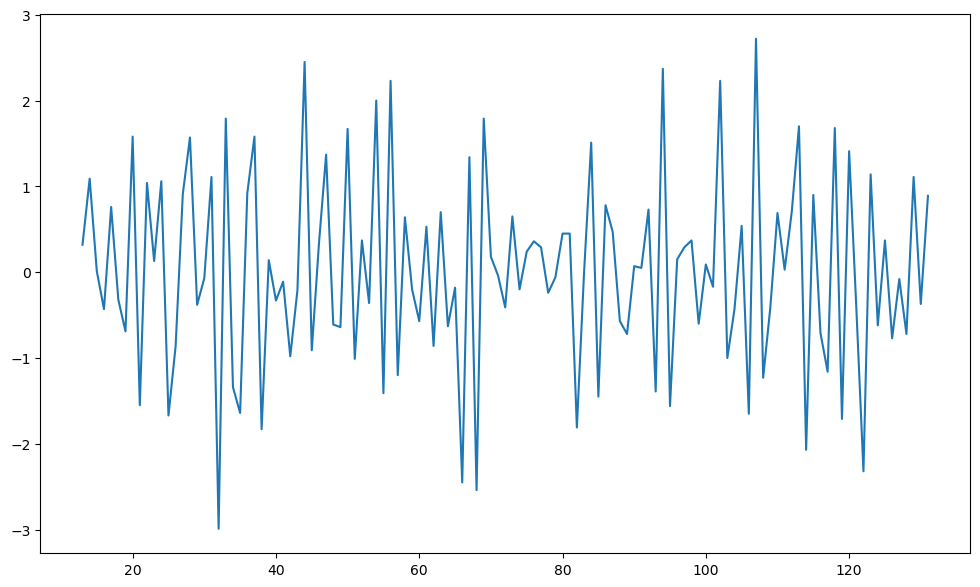

In [143]:
#We now take one more differencing; this time regular differencing
y2d = ydiff12.diff()
plt.figure(figsize = (12, 7))
plt.plot(y2d)
plt.show()

The sample ACF and PACF of this data is plotted using the code below. 

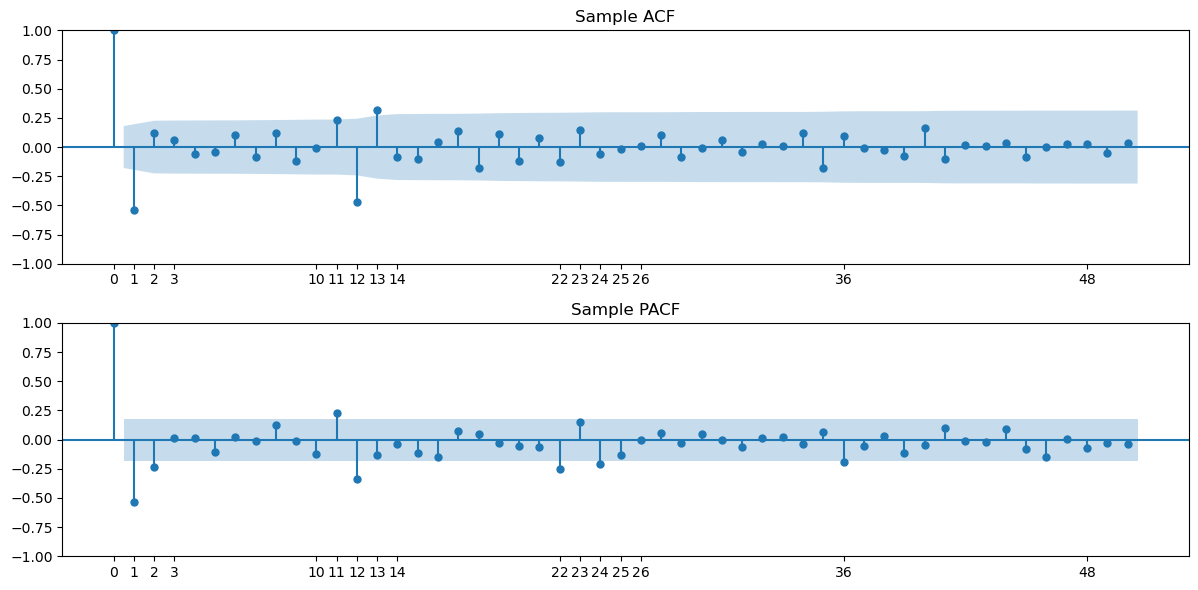

In [144]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(y2d.dropna(), lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
axes[0].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plot_pacf(y2d.dropna(), lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
axes[1].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plt.tight_layout()
plt.show()

The ACF has a large negative autocorrelation at lag one, and then a bunch of small autocorrelations followed by nonnegligible ones at lags 11, 12, 13. If we want to use an MA(q) model here, then $q = 13$ would be reasonable. But that model will have quite a few parameters. It would be preferable to have a simpler MA model with fewer parameters that has an ACF similar to the above sample ACF. To get such a model, we need to learn about seasonal and multiplicative seasonal ARMA models. 

## Seasonal ARMA models

Seasonal ARMA models are given by $\phi(B^s) (y_t - \mu) = \theta(B^s) \epsilon_t$. These are special cases of regular ARMA models with lots of zeros in the AR and MA coefficients. For example, the seasonal MA(1) model with period $s = 4$ is $y_t = \mu + \epsilon_t + \theta \epsilon_{t-4}$ which is also a regular MA(4) model with coefficients $\theta_1 = \theta_2 = \theta_3 = 0$ and $\theta_4 = \theta$. The following code is the same as that used previously to compute the ACF and PACF of ARMA processes. By inputting a bunch of zeros in ma_coeffs and ar_coeffs, we can obtain the ACF and PACF of seasonal ARMA models.

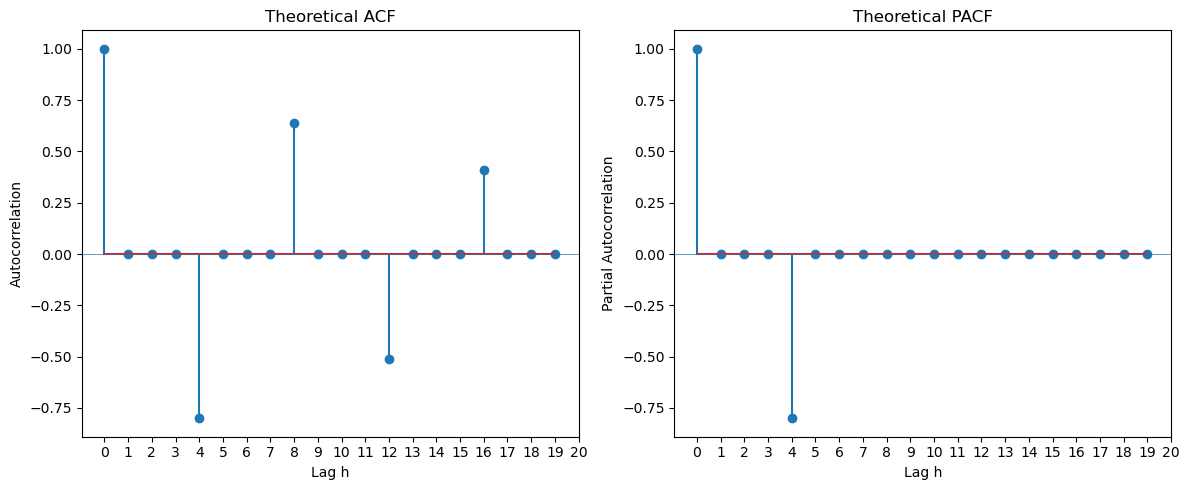

In [145]:
#AR(1)
th = 0.8
#ma_coeffs = [1, 0, 0, 0, th] #this corresponds to seasonal MA with period = 4
ma_coeffs = [1]
#ma_coeffs = [1, th]
#ph = 0.8
#ar_coeffs = [1]
#ar_coeffs = [1, -ph]
ar_coeffs = [1, 0, 0, 0, -ph] #this corresponds to seasonal AR with period = 4
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 20
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

The ACF and PACF of a seasonal ARMA model is non-zero only at the seasonal lags $h = 0, s, 2s, 3s, 4s, \dots$. At these seasonal lags, the ACF and PACF exactly equal those of the non-seasonal ARMA. 

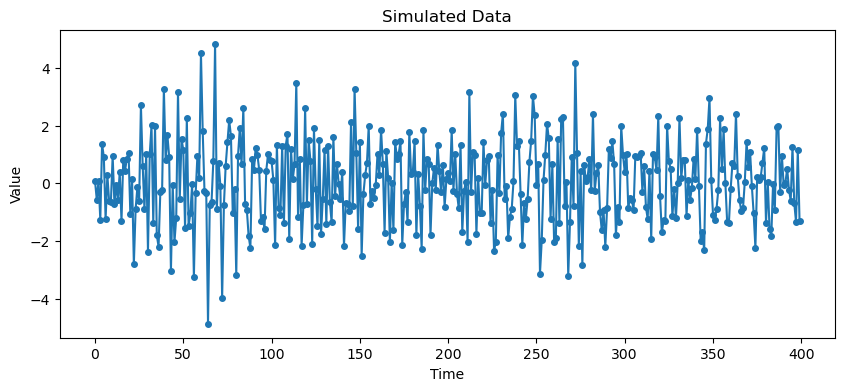

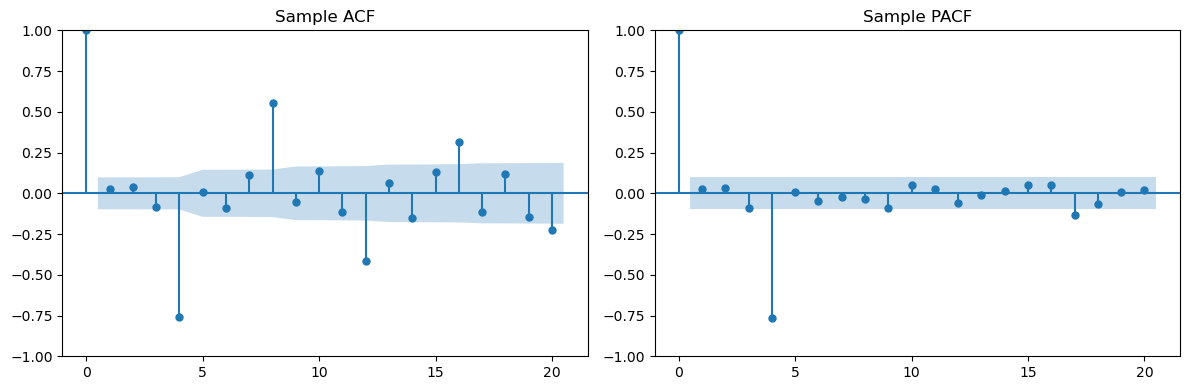

In [146]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

## Multiplicative Seasonal ARMA models

Next we look at the ACF and PACF of Multiplicative Seasonal ARMA models. These have aspects of both the usual ARMA models as well as the Seasonal ARMA models. It is a challenge to look at the ACF and PACF functions and guess the form of the model based on those plots. One can try the following heuristic strategy. First look at the ACF and PACF only at the seasonal lags $h = 0, s, 2s, 3s, \dots$. From here, try to guess the order of the seasonal part of the ARMA model. For example, if ACF(hs) seems to be negligible for $h > Q$, then the seasonal part could be MA(Q). If PACF(hs) seems negligible for $h > P$, then seasonal part could be AR(P). Next look at only the initial few non-seasonal lags ($h = 0, 1, 2, 3, \dots, s-1$). From here, attempt to guess the orders of the regular part of the model. 

First example is $ARMA(0, 0, 1) X (0, 0, 1)_{12}$ (which can be also written as $MA(1) \times MA(1)_{12}$). 

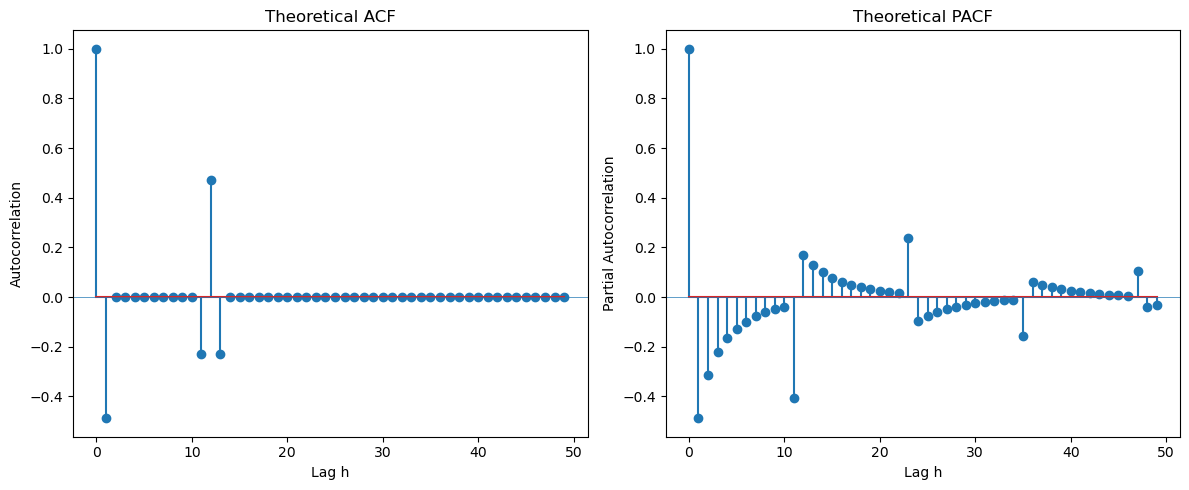

In [147]:
th = -0.8
Th = 0.7
ma_coeffs = np.zeros(14)
ma_coeffs[0] = 1
ma_coeffs[1] = th
ma_coeffs[12] = Th
ma_coeffs[13] = th*Th
#ma_coeffs = [1, 0, 0, 0, th]
#ma_coeffs = [1]
#ma_coeffs = [1, th]
#ph = 0.8
ar_coeffs = [1]
#ar_coeffs = [1, -ph]
#ar_coeffs = [1, 0, 0, 0, -ph]
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 50
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
#ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
#ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

From the ACF at seasonal lags, it is clear that the seasonal part is $MA(1)_{12}$. From the ACF at the initial few lags, it is clear that the regular part is also $MA(1)$, leading to the overall model $MA(1) \times MA(1)_{12}$.  

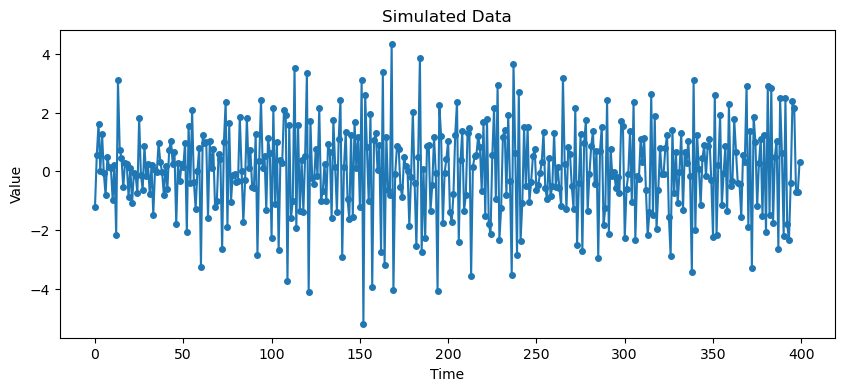

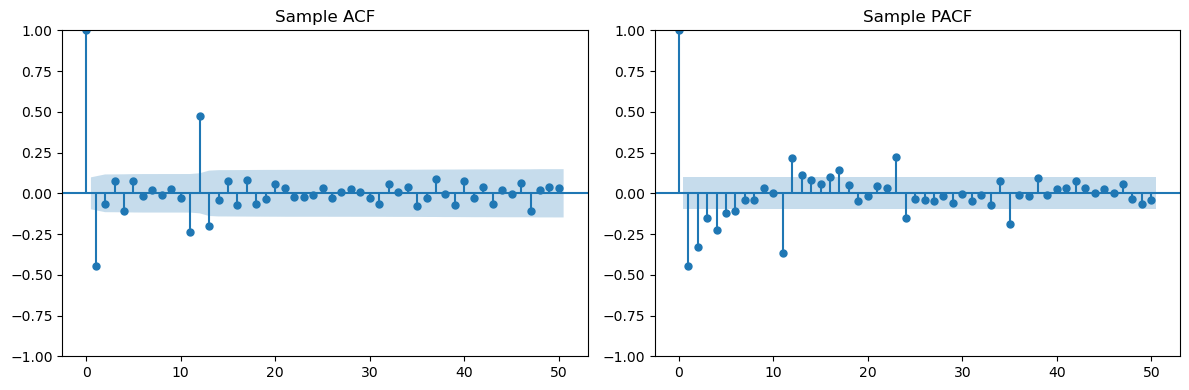

In [148]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

Second Example is $ARMA(0, 1) \times (1, 0)_{12}$ (which can also be written as $MA(1)) \times AR(1)_{12}$). 

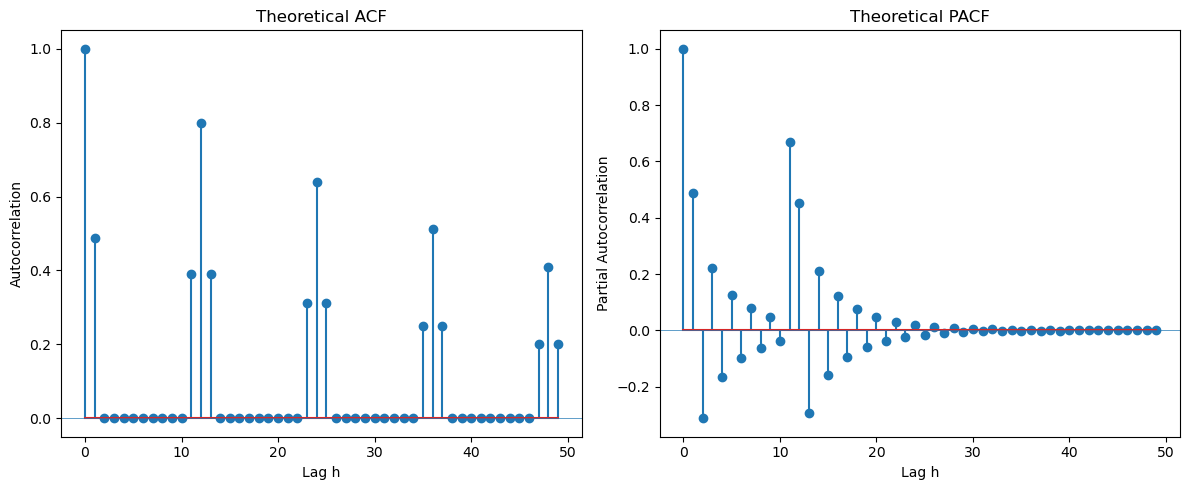

In [149]:
th = 0.8
ma_coeffs = np.array([1, th])
ph = 0.8
ar_coeffs = np.zeros(13)
ar_coeffs[0] = 1
ar_coeffs[12] = -ph
#ar_coeffs = [1, -ph]
#ar_coeffs = [1, 0, 0, 0, -ph]
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 50
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
#ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
#ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

From the PACF at the seasonal lags (12, 24, ...), there is only one spike (at lag 12) which suggests that the seasonal part is AR(1). Looking at the initial few lags (1, 2, 3, ...), the ACF reveals an MA(1) structure. The overall model can be guessed as $MA(1) \times AR(1)_{12}$. 

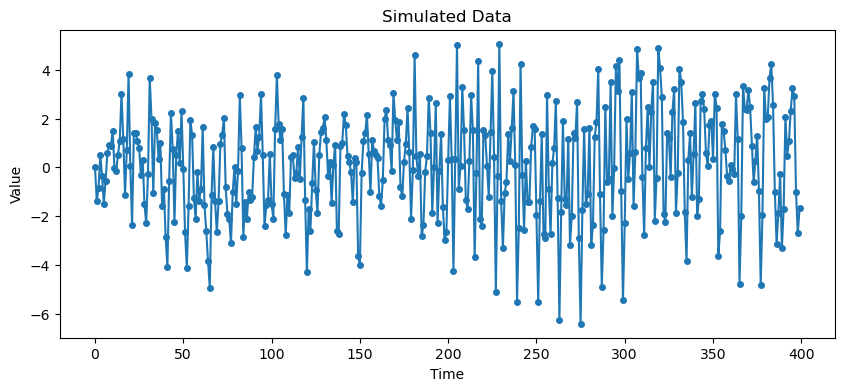

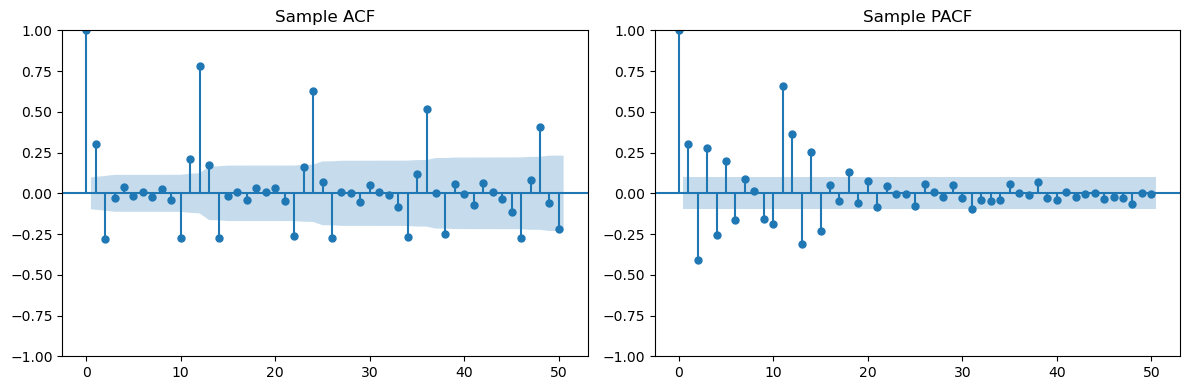

In [150]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

Example Three is $MA(2) \times AR(1)_{12}$. 

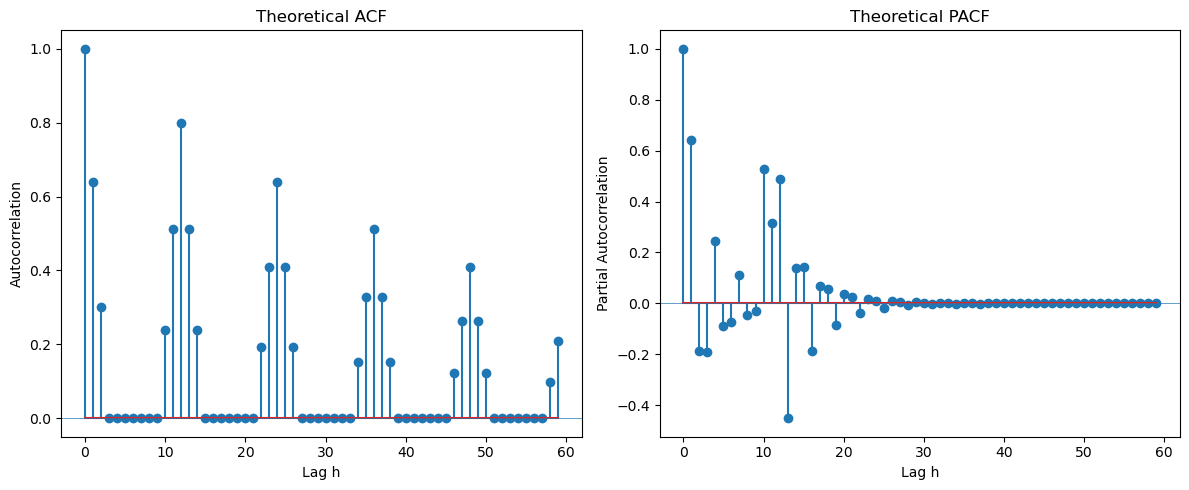

In [151]:
th1 = 0.8
th2 = 0.6
ma_coeffs = np.array([1, th1, th2])
ph = 0.8
ar_coeffs = np.zeros(13)
ar_coeffs[0] = 1
ar_coeffs[12] = -ph
#ar_coeffs = [1, -ph]
#ar_coeffs = [1, 0, 0, 0, -ph]
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 60
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
#ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
#ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

Looking at the seasonal lags (12, 24, 36, ...) in the PACF, we can clearly see only one spike suggesting $AR(1)_{12}$. Looking at lags 1, 2, 3, ... in the ACF, we see two spikes suggesting $MA(2)$. The overall model can be guessed as $MA(2) \times AR(1)_{12}$. 

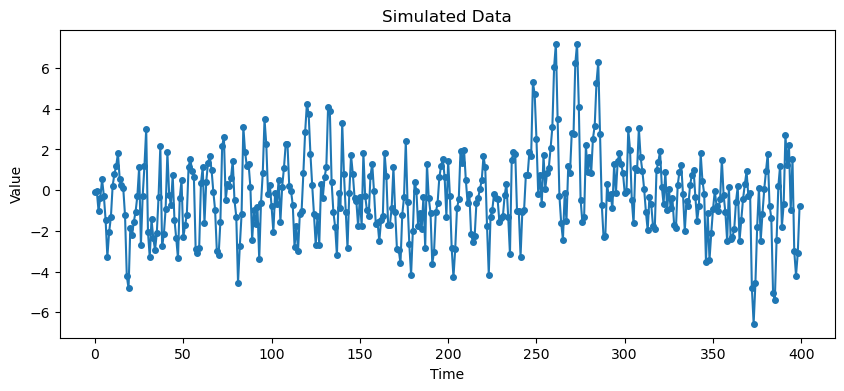

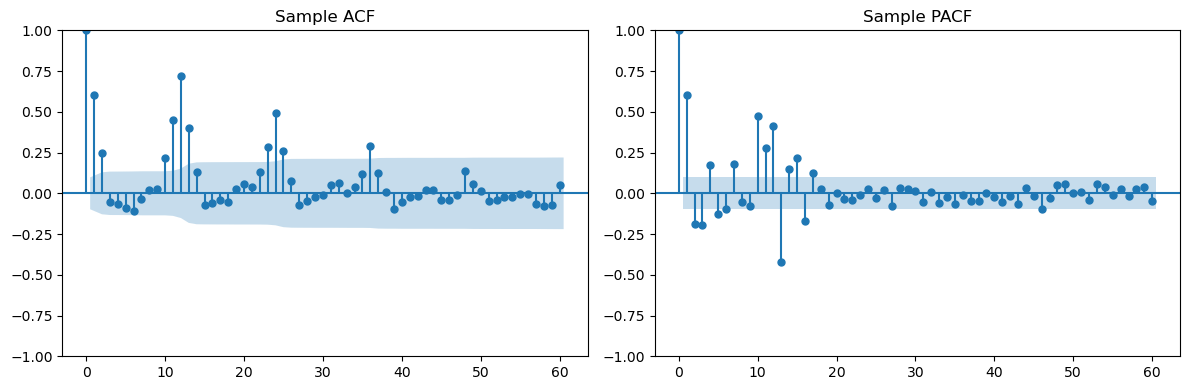

In [152]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

Example Four is $AR(1) \times AR(1)_{12}$. 

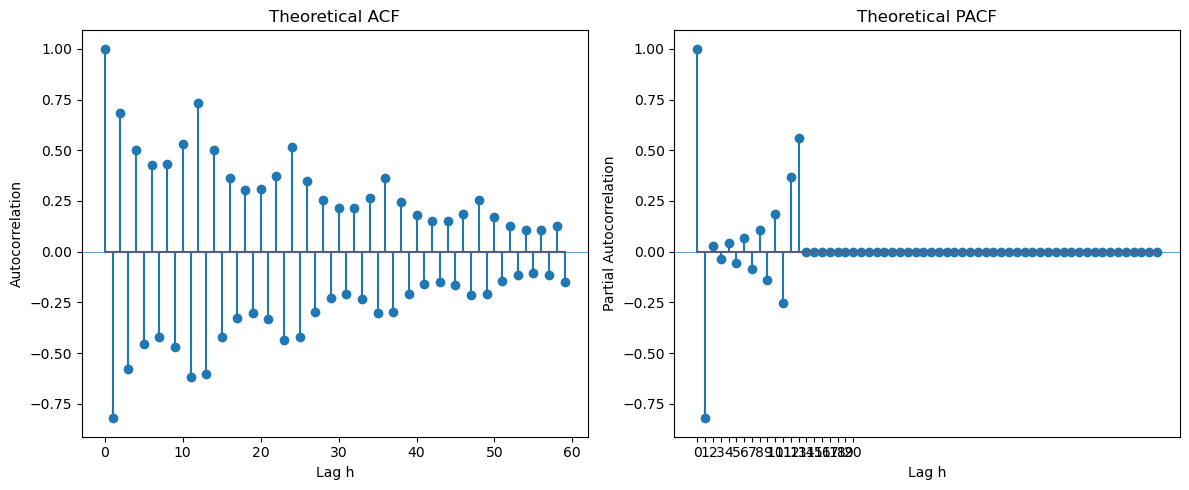

In [153]:
ph = -0.8
Ph = 0.7
ar_coeffs = np.zeros(14)
ar_coeffs[0] = 1
ar_coeffs[1] = -ph
ar_coeffs[12] = -Ph
ar_coeffs[13] = ph*Ph
ma_coeffs = [1]
L = 60
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
#ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

At the seasonal lags 12, 24, 36, ..., the PACF has one spike suggesting $AR(1)_{12}$. At lags 1, 2, 3, ..., there is also one spike in the PACF suggesting $AR(1)$. The overall model is therefore guessed as $AR(1) \times AR(1)_{12}$. 

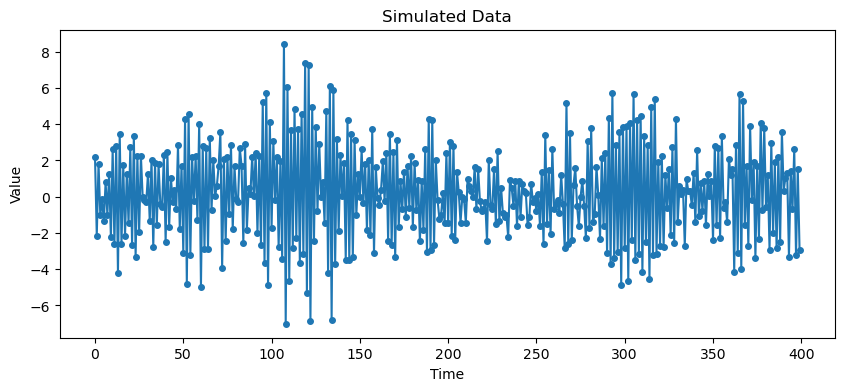

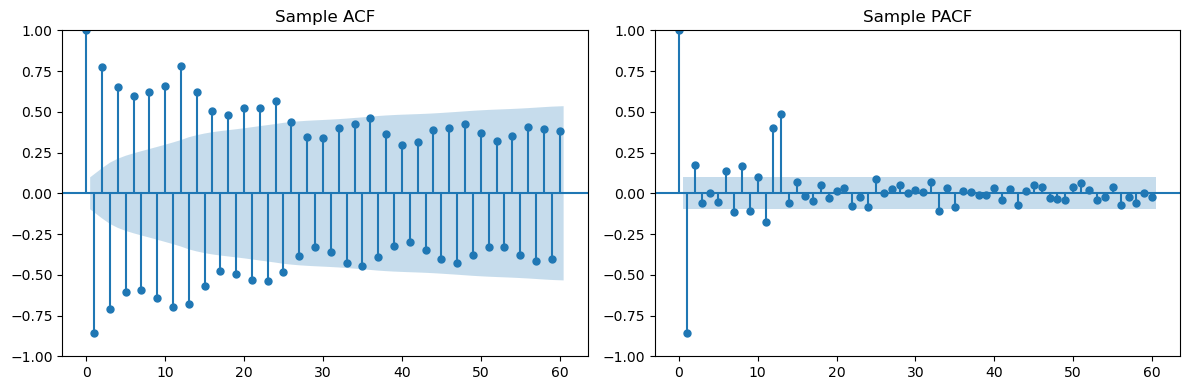

In [154]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

In all the examples, it is much harder (due to noise) to guess the models from the sample ACF and PACFs (from data generated according to the model) compared to the  theoretical ACF and PACF of the model. 

## Back to co2 dataset

Let us now get back to the co2 dataset and fit a suitable SARIMA model. 

In [155]:
co2 = pd.read_csv('co2_TSA.csv')
print(co2)
y = co2['x']

     Unnamed: 0       x
0             1  363.05
1             2  364.18
2             3  364.87
3             4  364.47
4             5  364.32
..          ...     ...
127         128  368.69
128         129  368.55
129         130  373.39
130         131  378.49
131         132  381.62

[132 rows x 2 columns]


In [156]:
ydiff12 = y.diff(periods = 12)
y2d = ydiff12.diff()

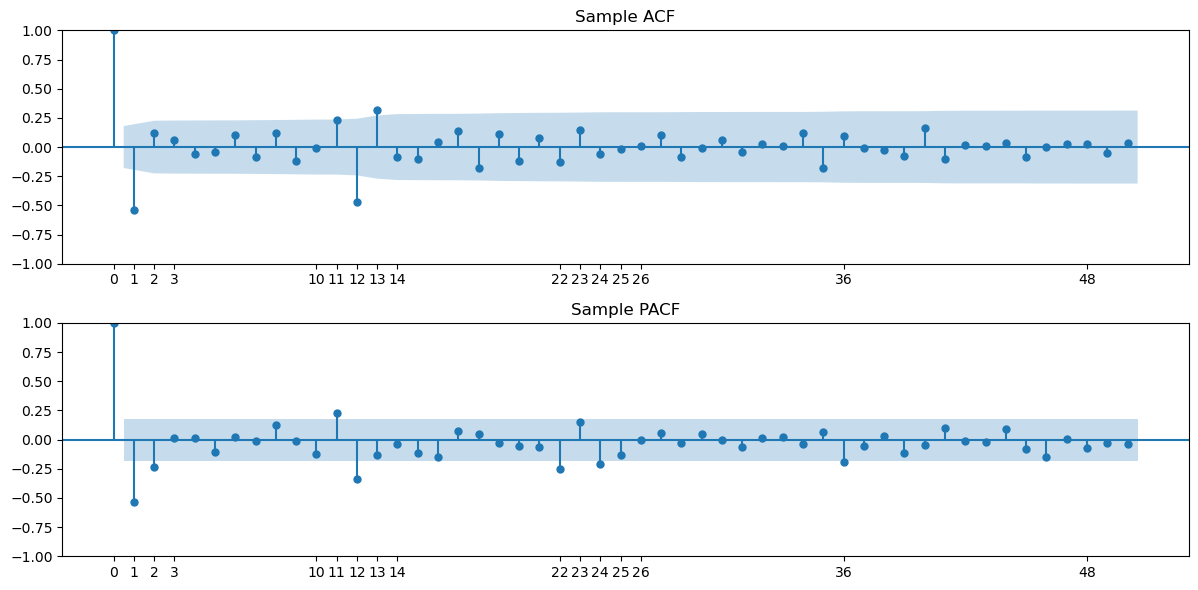

In [157]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(y2d.dropna(), lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
axes[0].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plot_pacf(y2d.dropna(), lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
axes[1].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plt.tight_layout()
plt.show()

From the sample ACF and PACF, it can be argued that $MA(1) \times MA(1)_{12}$ is a suitable model for the twice differenced data $\nabla_s \nabla y_t$. To see this, let us first focus only on the seasonal lags 12, 24, 36 etc., for the ACF function at these lags, there is only one spike (at lag 12) which suggests $MA(1)_{12}$. Next let us look at the regular (i.e., non-seasonal) initial lags 1,2,3,4 etc. Here also in the ACF, there is a single spike suggesting regular $MA(1)$. The overall model is therefore $MA(1) \times MA(1)_{12}$.

We can fit this using the ARIMA function as shown below. 

In [158]:
m1_co2 = ARIMA(y, order = (0, 1, 1), seasonal_order = (0, 1, 1, 12)).fit()
print(m1_co2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                x   No. Observations:                  132
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -139.547
Date:                          Thu, 20 Nov 2025   AIC                            285.095
Time:                                  23:00:16   BIC                            293.432
Sample:                                       0   HQIC                           288.481
                                          - 132                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5791      0.093     -6.254      0.000      -0.761      -0.398
ma.S.L12      -0.8205      0.117     -7.017      0.

Predictions using this fitted ARIMA model are obtained in the usual way via the get_prediction function. 

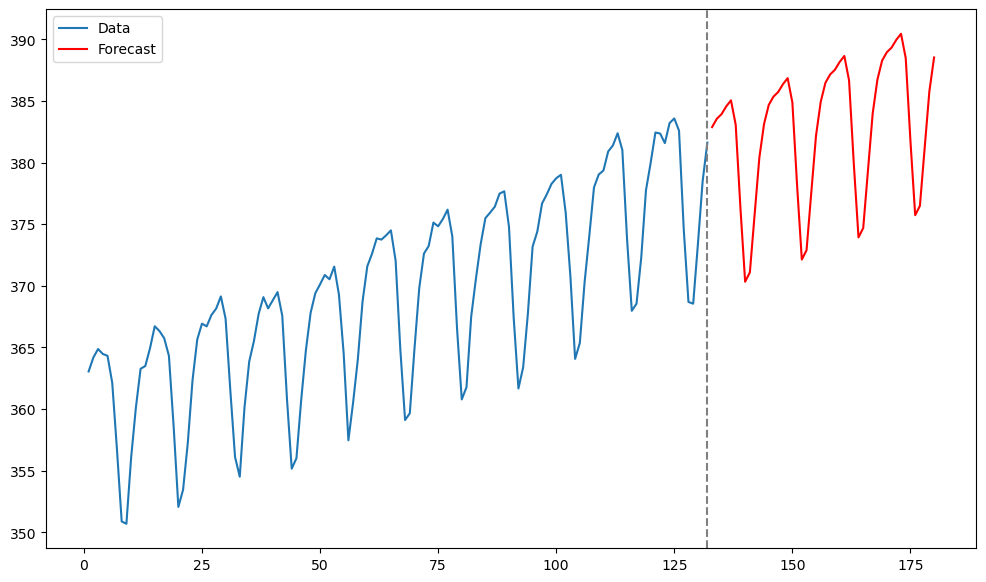

In [159]:
k = 48
n = len(y)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
fcast = m1_co2.get_prediction(start = n, end = n+k-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast', color = 'red')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

## Airline passengers dataset

The airline passengers dataset is a popular dataset for evaluating prediction accuracy of various models. It contains monthly data on the number of international airline passengers (in thousands) from January 1949 to December 1960. 

          time  value
0  1949.000000    112
1  1949.083333    118
2  1949.166667    132
3  1949.250000    129
4  1949.333333    121


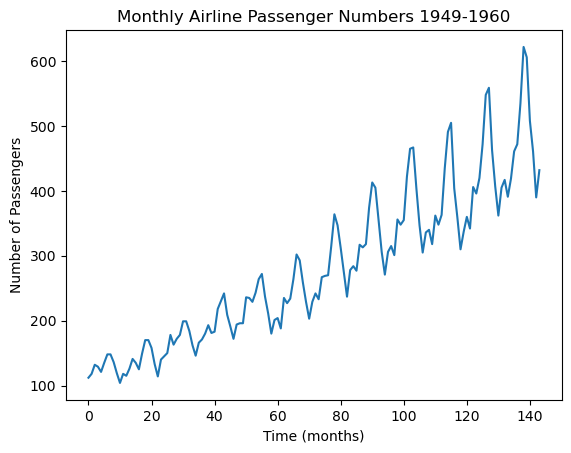

In [160]:
data = sm.datasets.get_rdataset("AirPassengers").data
print(data.head())
y = data['value'].to_numpy()
plt.plot(y)
plt.xlabel('Time (months)')
plt.ylabel('Number of Passengers')
plt.title('Monthly Airline Passenger Numbers 1949-1960')
plt.show()

As usual, we fit models to logarithms. 

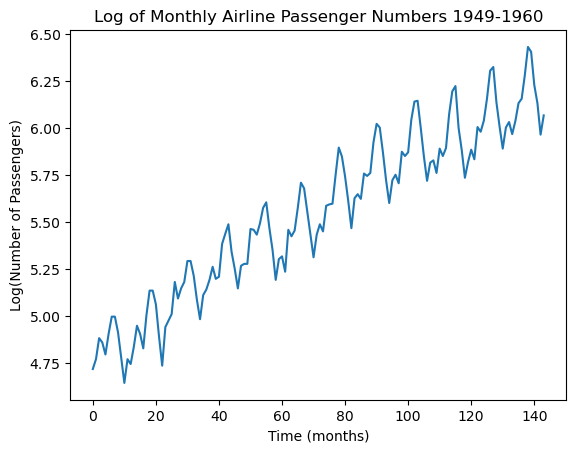

In [161]:
ylog = np.log(y)
plt.plot(ylog)
plt.xlabel('Time (months)')
plt.ylabel('Log(Number of Passengers)')
plt.title('Log of Monthly Airline Passenger Numbers 1949-1960')
plt.show()

We first take seasonal differences: $\log y_t - \log y_{t-12}$. 

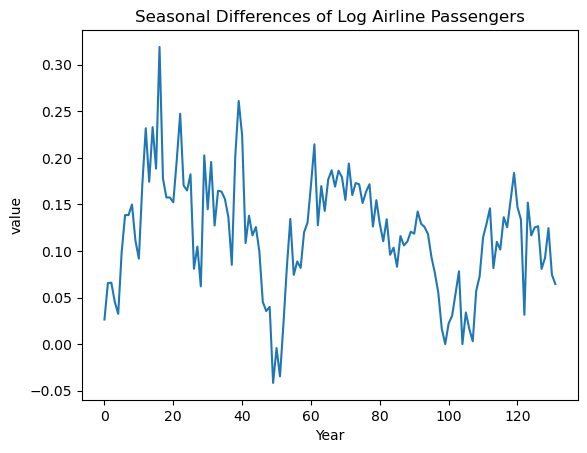

In [162]:
#Seasonal differencing: y_t - y_{t-12}
ylogdiff12 = ylog[12:] - ylog[:-12]
plt.plot(ylogdiff12)
plt.xlabel('Year')
plt.ylabel('value')
plt.title('Seasonal Differences of Log Airline Passengers')
plt.show()

There are still some increasing/decreasing trends. Let us now take regular differences. 

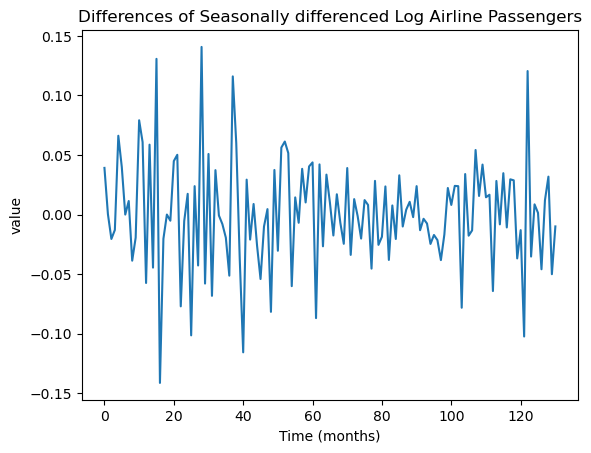

In [163]:
#We now take one more differencing; this time regular differencing
ylog2d = np.diff(ylogdiff12)
plt.plot(ylog2d)
plt.xlabel('Time (months)')
plt.ylabel('value')
plt.title('Differences of Seasonally differenced Log Airline Passengers')
plt.show()

We can now look at the ACF and PACF to assess if a multiplicative seasonal ARMA model is appropriate. 

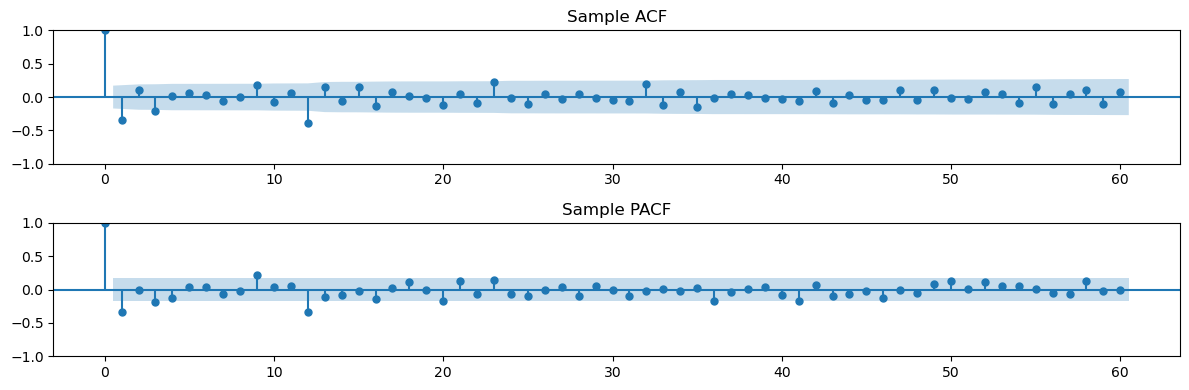

In [164]:
L = 60
# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))
plot_acf(ylog2d, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(ylog2d, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

Two simple models for this dataset are: $MA(0, 1) \times MA(0, 1)_{12}$ or $AR(1, 0) \times AR(1, 0)_{12}$. For the original ylog, these models would be $ARIMA(0, 1, 1) \times (0, 1, 1)_{12}$ and $ARIMA(1, 1, 0) \times (1, 1, 0)_{12}$. Below we fit these models. 

In [165]:
#Fit these models: 
m1 = ARIMA(ylog, order = (0, 1, 1), seasonal_order = (0, 1, 1, 12)).fit()
print(m1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  144
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                          Thu, 20 Nov 2025   AIC                           -483.393
Time:                                  23:00:26   BIC                           -474.767
Sample:                                       0   HQIC                          -479.888
                                          - 144                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.073     -5.503      0.000      -0.545      -0.259
ma.S.L12      -0.5570      0.096     -5.785      0.

In [166]:
m2 = ARIMA(ylog, order = (1, 1, 0), seasonal_order = (1, 1, 0, 12)).fit()
print(m2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  144
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 240.406
Date:                          Thu, 20 Nov 2025   AIC                           -474.813
Time:                                  23:00:27   BIC                           -466.187
Sample:                                       0   HQIC                          -471.308
                                          - 144                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3747      0.071     -5.273      0.000      -0.514      -0.235
ar.S.L12      -0.4636      0.071     -6.510      0.

Here are the predictions by these two models.

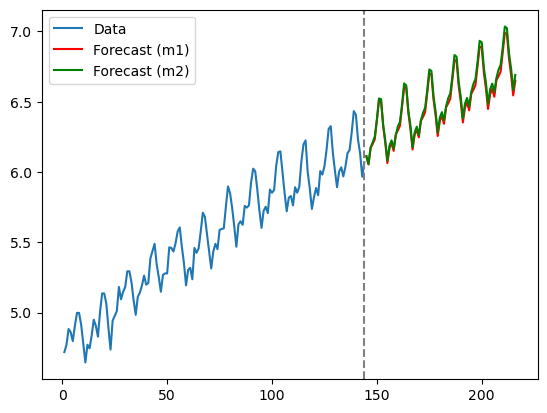

In [167]:
k = 72
n = len(ylog)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
fcast_1 = m1.get_prediction(start = n, end = n+k-1).predicted_mean
fcast_2 = m2.get_prediction(start = n, end = n+k-1).predicted_mean
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Forecast (m1)', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Forecast (m2)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The predictions are quite similar to each other. 

Below we loop over a set of values of $p, d, q$ and $P, D, Q$ to find the best models (in terms of AIC and BIC). 

In [168]:
import warnings
warnings.filterwarnings("ignore") #this suppresses convergence warnings. 


dt = ylog
pmax, dmax, qmax = 2, 1, 2
Pmax, D, Qmax = 2, 1, 2
seasonal_period = 12

results = []

for p in range(pmax + 1):
    for d in range(dmax + 1):
        for q in range(qmax + 1):
            for P in range(Pmax + 1):
                for Q in range(Qmax + 1):
                    try:
                        model = ARIMA(dt, 
                                      order=(p, d, q), 
                                      seasonal_order=(P, D, Q, seasonal_period)).fit()
                        results.append({
                            'p': p, 'd': d, 'q': q,
                            'P': P, 'D': D, 'Q': Q,
                            'AIC': model.aic,
                            'BIC': model.bic
                        })
                    # Progress message
                        print(f"Successfully fit ARIMA({p},{d},{q})x({P},{D},{Q})")
                    except Exception as e:
                        print(f"ARIMA({p},{d},{q})x({P},{D},{Q}) failed: {e}")
                        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best models
best_aic_idx = results_df['AIC'].idxmin()
best_bic_idx = results_df['BIC'].idxmin()

best_aic_model = results_df.loc[best_aic_idx]
best_bic_model = results_df.loc[best_bic_idx]

# Display results
print("Best model by AIC:")
print(best_aic_model)

print("\nBest model by BIC:")
print(best_bic_model)

Successfully fit ARIMA(0,0,0)x(0,1,0)
Successfully fit ARIMA(0,0,0)x(0,1,1)
Successfully fit ARIMA(0,0,0)x(0,1,2)
Successfully fit ARIMA(0,0,0)x(1,1,0)
Successfully fit ARIMA(0,0,0)x(1,1,1)
Successfully fit ARIMA(0,0,0)x(1,1,2)
Successfully fit ARIMA(0,0,0)x(2,1,0)
Successfully fit ARIMA(0,0,0)x(2,1,1)
Successfully fit ARIMA(0,0,0)x(2,1,2)
Successfully fit ARIMA(0,0,1)x(0,1,0)
Successfully fit ARIMA(0,0,1)x(0,1,1)
Successfully fit ARIMA(0,0,1)x(0,1,2)
Successfully fit ARIMA(0,0,1)x(1,1,0)
Successfully fit ARIMA(0,0,1)x(1,1,1)
Successfully fit ARIMA(0,0,1)x(1,1,2)
Successfully fit ARIMA(0,0,1)x(2,1,0)
Successfully fit ARIMA(0,0,1)x(2,1,1)
Successfully fit ARIMA(0,0,1)x(2,1,2)
Successfully fit ARIMA(0,0,2)x(0,1,0)
Successfully fit ARIMA(0,0,2)x(0,1,1)
Successfully fit ARIMA(0,0,2)x(0,1,2)
Successfully fit ARIMA(0,0,2)x(1,1,0)
Successfully fit ARIMA(0,0,2)x(1,1,1)
Successfully fit ARIMA(0,0,2)x(1,1,2)
Successfully fit ARIMA(0,0,2)x(2,1,0)
Successfully fit ARIMA(0,0,2)x(2,1,1)
Successfully

The best model in terms of AIC corresponds to $(1, 0, 1) \times (1, 1, 2)_{12}$, and the best model is terms of BIC is $(0, 1, 1) \times (0, 1, 1)_{12}$ (this is the $MA(1) \times MA(1)_{12}$ model for $\nabla \nabla^{12} y_t$). This latter model is just $m1$. 

In [169]:
m3 = ARIMA(ylog, order=(1,0,1), seasonal_order=(1,1,2,12)).fit()
print(m3.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  144
Model:             ARIMA(1, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood                 248.528
Date:                               Thu, 20 Nov 2025   AIC                           -485.056
Time:                                       23:02:42   BIC                           -467.759
Sample:                                            0   HQIC                          -478.027
                                               - 144                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9925      0.008    121.715      0.000       0.977       1.009
ma.L1      

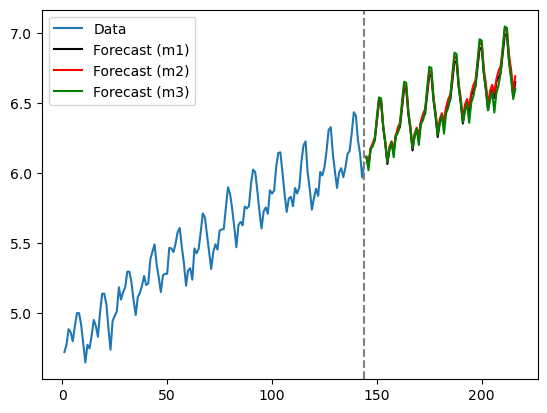

In [170]:
n = len(ylog)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
fcast_3 = m3.get_prediction(start = n, end = n+k-1).predicted_mean
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Forecast (m1)', color = 'black')
plt.plot(tme_future, fcast_2, label = 'Forecast (m2)', color = 'red')
plt.plot(tme_future, fcast_3, label = 'Forecast (m3)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Here are the predictions on the original data (without logarithms). 

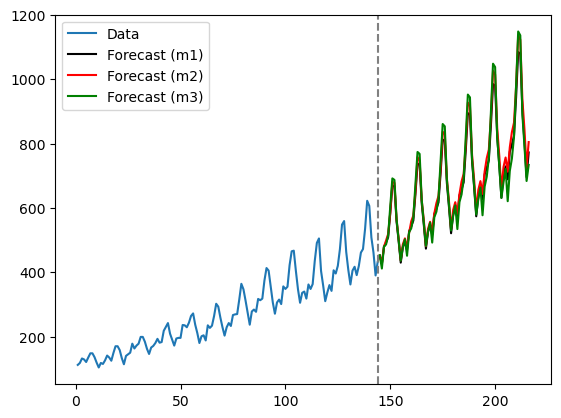

In [171]:
plt.plot(tme, y, label = 'Data')
plt.plot(tme_future, np.exp(fcast_1), label = 'Forecast (m1)', color = 'black')
plt.plot(tme_future, np.exp(fcast_2), label = 'Forecast (m2)', color = 'red')
plt.plot(tme_future, np.exp(fcast_3), label = 'Forecast (m3)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The predictions are largely similar especially for future time points that are in the near future.

### Retail Alcohol Sales Data

Let us now consider the following data from FRED. 

  observation_date  MRTSSM4453USN
0       1992-01-01           1414
1       1992-02-01           1444
2       1992-03-01           1496
3       1992-04-01           1569
4       1992-05-01           1707


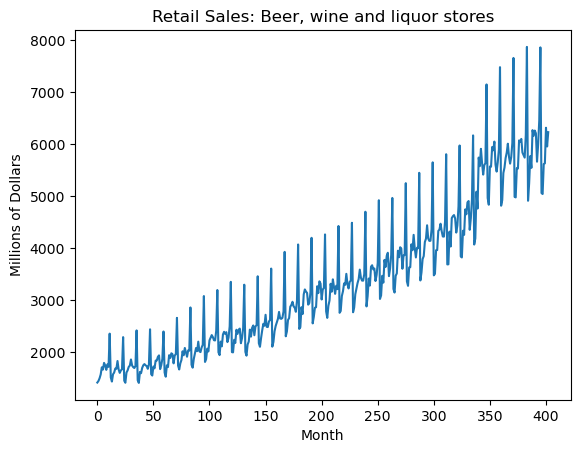

In [172]:
#The following is FRED data on retail sales (in millions of dollars) for beer, wine and liquor stores (https://fred.stlouisfed.org/series/MRTSSM4453USN)
beersales = pd.read_csv('MRTSSM4453USN_19Nov2025.csv')
print(beersales.head())
y = beersales['MRTSSM4453USN']
plt.plot(y)
plt.xlabel('Month')
plt.ylabel('Millions of Dollars')
plt.title('Retail Sales: Beer, wine and liquor stores')
plt.show()

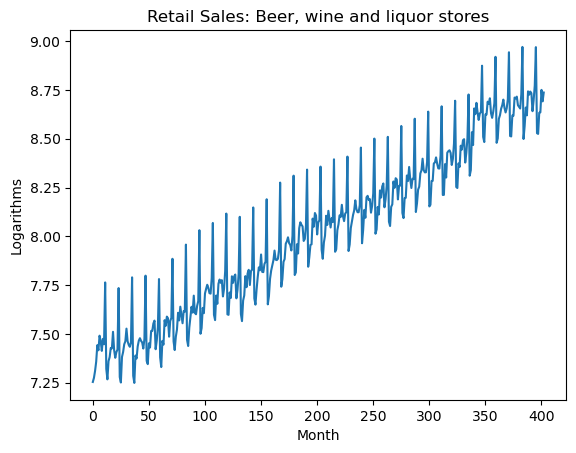

In [173]:
ylog = np.log(y)
plt.plot(ylog)
plt.xlabel('Month')
plt.ylabel('Logarithms')
plt.title('Retail Sales: Beer, wine and liquor stores')
plt.show()

In order to fit a stationary model, let us first preprocess by differencing. The seasonal differences are calculated and plotted below. 

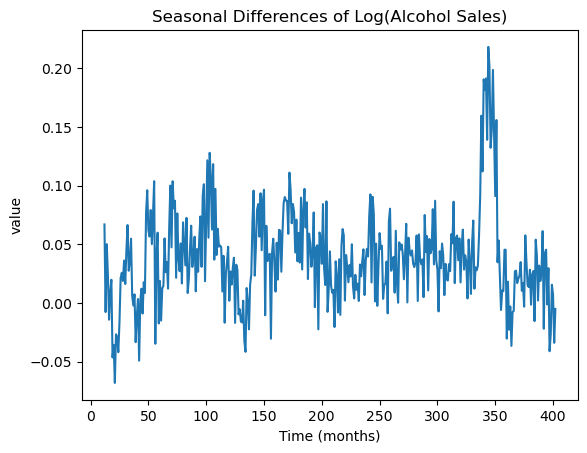

In [174]:
#Seasonal differencing: y_t - y_{t-12}
ylogdiff12 = ylog.diff(periods = 12)
plt.plot(ylogdiff12)
plt.xlabel('Time (months)')
plt.ylabel('value')
plt.title('Seasonal Differences of Log(Alcohol Sales)')
plt.show()


Certain increasing/decreasing trends are visible in the above data. We do one more differencing below. 

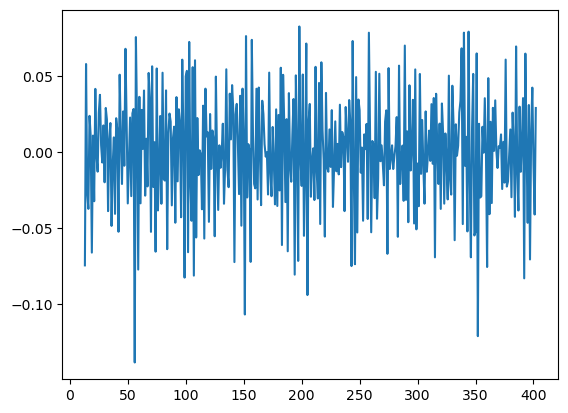

In [180]:
#We now take one more differencing; this time regular differencing
ylog2d = ylogdiff12.diff()
plt.plot(ylog2d)
plt.show()

Now let us compute the ACF and PACF. 

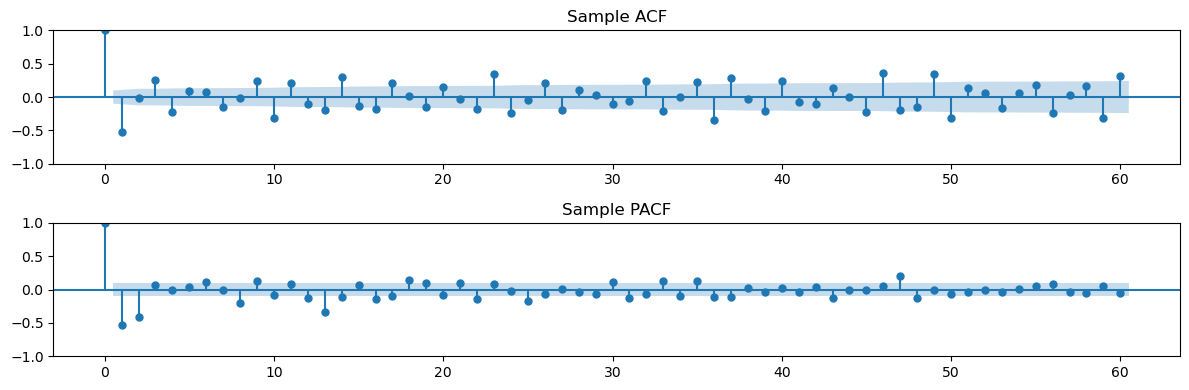

In [181]:
L = 60
# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))
plot_acf(ylog2d.dropna(), lags=L, ax=ax1, title='Sample ACF')
plot_pacf(ylog2d.dropna(), lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

It appears  hard to determine the orders for an appropriate SARIMA model directly from the above ACF and PACF plot. Below we use a brute force approach where we enumerate a whole bunch of $ARIMA(p, d, q) \times (P, D, Q)_{12}$ models, and then pick the best model via the AIC and BIC criteria. 

In [182]:
import warnings
warnings.filterwarnings("ignore") #this suppresses convergence warnings. 


dt = ylog
pmax, dmax, qmax = 2, 1, 2
Pmax, D, Qmax = 2, 1, 2
seasonal_period = 12

results = []

for p in range(pmax + 1):
    for d in range(dmax + 1):
        for q in range(qmax + 1):
            for P in range(Pmax + 1):
                for Q in range(Qmax + 1):
                    try:
                        model = ARIMA(dt, 
                                      order=(p, d, q), 
                                      seasonal_order=(P, D, Q, seasonal_period)).fit()
                        results.append({
                            'p': p, 'd': d, 'q': q,
                            'P': P, 'D': D, 'Q': Q,
                            'AIC': model.aic,
                            'BIC': model.bic
                        })
                    # Progress message
                        print(f"Successfully fit ARIMA({p},{d},{q})x({P},{D},{Q})")
                    except Exception as e:
                        print(f"ARIMA({p},{d},{q})x({P},{D},{Q}) failed: {e}")
                        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best models
best_aic_idx = results_df['AIC'].idxmin()
best_bic_idx = results_df['BIC'].idxmin()

best_aic_model = results_df.loc[best_aic_idx]
best_bic_model = results_df.loc[best_bic_idx]

# Display results
print("Best model by AIC:")
print(best_aic_model)

print("\nBest model by BIC:")
print(best_bic_model)

Successfully fit ARIMA(0,0,0)x(0,1,0)
Successfully fit ARIMA(0,0,0)x(0,1,1)
Successfully fit ARIMA(0,0,0)x(0,1,2)
Successfully fit ARIMA(0,0,0)x(1,1,0)
Successfully fit ARIMA(0,0,0)x(1,1,1)
Successfully fit ARIMA(0,0,0)x(1,1,2)
Successfully fit ARIMA(0,0,0)x(2,1,0)
Successfully fit ARIMA(0,0,0)x(2,1,1)
Successfully fit ARIMA(0,0,0)x(2,1,2)
Successfully fit ARIMA(0,0,1)x(0,1,0)
Successfully fit ARIMA(0,0,1)x(0,1,1)
Successfully fit ARIMA(0,0,1)x(0,1,2)
Successfully fit ARIMA(0,0,1)x(1,1,0)
Successfully fit ARIMA(0,0,1)x(1,1,1)
Successfully fit ARIMA(0,0,1)x(1,1,2)
Successfully fit ARIMA(0,0,1)x(2,1,0)
Successfully fit ARIMA(0,0,1)x(2,1,1)
Successfully fit ARIMA(0,0,1)x(2,1,2)
Successfully fit ARIMA(0,0,2)x(0,1,0)
Successfully fit ARIMA(0,0,2)x(0,1,1)
Successfully fit ARIMA(0,0,2)x(0,1,2)
Successfully fit ARIMA(0,0,2)x(1,1,0)
Successfully fit ARIMA(0,0,2)x(1,1,1)
Successfully fit ARIMA(0,0,2)x(1,1,2)
Successfully fit ARIMA(0,0,2)x(2,1,0)
Successfully fit ARIMA(0,0,2)x(2,1,1)
Successfully

Of the considered models, the best AIC model is $ARIMA(2, 1, 0) \times (2, 1, 2)_{12}$ and the best BIC model is $ARIMA(2, 1, 0) \times (0, 1, 2)_{12}$. We fit these models below. If we do not suppress warnings, we will see a bunch of warnings. Fitting these models is not easy and the process involves nonlinear optimization for calculating the MLEs.  

In [183]:
m1 = ARIMA(ylog, order = (2, 1, 0), seasonal_order = (2, 1, 2, 12)).fit()
print(m1.summary())

                                       SARIMAX Results                                       
Dep. Variable:                         MRTSSM4453USN   No. Observations:                  403
Model:             ARIMA(2, 1, 0)x(2, 1, [1, 2], 12)   Log Likelihood                 885.728
Date:                               Thu, 20 Nov 2025   AIC                          -1757.455
Time:                                       23:10:47   BIC                          -1729.692
Sample:                                            0   HQIC                         -1746.450
                                               - 403                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6115      0.053    -11.624      0.000      -0.715      -0.508
ar.L2      

In [184]:
m2 = ARIMA(ylog, order = (2, 1, 0), seasonal_order = (0, 1, 2, 12)).fit()
print(m2.summary())

                                       SARIMAX Results                                       
Dep. Variable:                         MRTSSM4453USN   No. Observations:                  403
Model:             ARIMA(2, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                 880.612
Date:                               Thu, 20 Nov 2025   AIC                          -1751.223
Time:                                       23:10:50   BIC                          -1731.393
Sample:                                            0   HQIC                         -1743.362
                                               - 403                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7730      0.049    -15.816      0.000      -0.869      -0.677
ar.L2      

Below we obtain predictions using both the models.

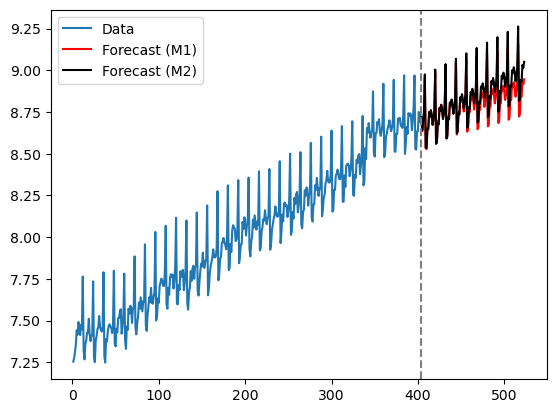

In [185]:
k = 120
n = len(ylog)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
fcast1 = m1.get_prediction(start = n, end = n+k-1).predicted_mean
fcast2 = m2.get_prediction(start = n, end = n+k-1).predicted_mean
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast1, label = 'Forecast (M1)', color = 'red')
plt.plot(tme_future, fcast2, label = 'Forecast (M2)', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The predictions by both models seem reasonable, and they are also very close to each other. Below we convert these predictions to the original data (not logarithms). 

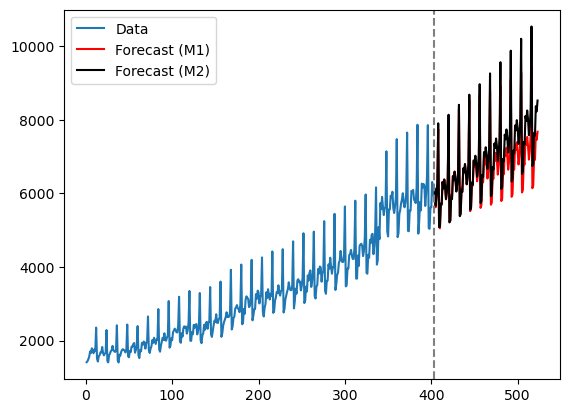

In [186]:
plt.plot(tme, y, label = 'Data')
plt.plot(tme_future, np.exp(fcast1), label = 'Forecast (M1)', color = 'red')
plt.plot(tme_future, np.exp(fcast2), label = 'Forecast (M2)', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

## FRED Industrial Production Dataset

The following dataset is from FRED (see https://fred.stlouisfed.org/series/IPB50001N). It gives monthly data on the Industrial Production (IP) index which measures the total industrial output and is indicative of the health of the economy. 

  observation_date  IPB50001N
0       1919-01-01     4.7841
1       1919-02-01     4.5959
2       1919-03-01     4.4884
3       1919-04-01     4.5691
4       1919-05-01     4.7035


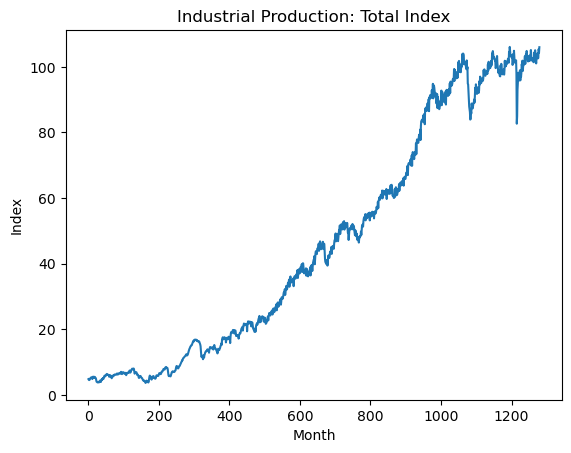

In [187]:
ip = pd.read_csv('IPB50001N _20Nov2025.csv')
print(ip.head())
y = ip['IPB50001N'].to_numpy()
plt.plot(y)
plt.xlabel('Month')
plt.ylabel('Index')
plt.title('Industrial Production: Total Index')
plt.show()

An older version of this dataset was analyzed in the book Shumway and Stoffer (see Example 3.46 in the fourth edition). Their first step is to take first order differences of the data. 

In [188]:
import warnings
warnings.filterwarnings("ignore") #this suppresses convergence warnings. 


dt = y
pmax, dmax, qmax = 2, 1, 2
Pmax, D, Qmax = 2, 1, 2
seasonal_period = 12

results = []

for p in range(pmax + 1):
    for d in range(dmax + 1):
        for q in range(qmax + 1):
            for P in range(Pmax + 1):
                for Q in range(Qmax + 1):
                    try:
                        model = ARIMA(dt, 
                                      order=(p, d, q), 
                                      seasonal_order=(P, D, Q, seasonal_period)).fit()
                        results.append({
                            'p': p, 'd': d, 'q': q,
                            'P': P, 'D': D, 'Q': Q,
                            'AIC': model.aic,
                            'BIC': model.bic
                        })
                    # Progress message
                        print(f"Successfully fit ARIMA({p},{d},{q})x({P},{D},{Q})")
                    except Exception as e:
                        print(f"ARIMA({p},{d},{q})x({P},{D},{Q}) failed: {e}")
                        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best models
best_aic_idx = results_df['AIC'].idxmin()
best_bic_idx = results_df['BIC'].idxmin()

best_aic_model = results_df.loc[best_aic_idx]
best_bic_model = results_df.loc[best_bic_idx]

# Display results
print("Best model by AIC:")
print(best_aic_model)

print("\nBest model by BIC:")
print(best_bic_model)

Successfully fit ARIMA(0,0,0)x(0,1,0)
Successfully fit ARIMA(0,0,0)x(0,1,1)
Successfully fit ARIMA(0,0,0)x(0,1,2)
Successfully fit ARIMA(0,0,0)x(1,1,0)
Successfully fit ARIMA(0,0,0)x(1,1,1)
Successfully fit ARIMA(0,0,0)x(1,1,2)
Successfully fit ARIMA(0,0,0)x(2,1,0)
Successfully fit ARIMA(0,0,0)x(2,1,1)
Successfully fit ARIMA(0,0,0)x(2,1,2)
Successfully fit ARIMA(0,0,1)x(0,1,0)
Successfully fit ARIMA(0,0,1)x(0,1,1)
Successfully fit ARIMA(0,0,1)x(0,1,2)
Successfully fit ARIMA(0,0,1)x(1,1,0)
Successfully fit ARIMA(0,0,1)x(1,1,1)
Successfully fit ARIMA(0,0,1)x(1,1,2)
Successfully fit ARIMA(0,0,1)x(2,1,0)
Successfully fit ARIMA(0,0,1)x(2,1,1)
Successfully fit ARIMA(0,0,1)x(2,1,2)
Successfully fit ARIMA(0,0,2)x(0,1,0)
Successfully fit ARIMA(0,0,2)x(0,1,1)
Successfully fit ARIMA(0,0,2)x(0,1,2)
Successfully fit ARIMA(0,0,2)x(1,1,0)
Successfully fit ARIMA(0,0,2)x(1,1,1)
Successfully fit ARIMA(0,0,2)x(1,1,2)
Successfully fit ARIMA(0,0,2)x(2,1,0)
Successfully fit ARIMA(0,0,2)x(2,1,1)
Successfully

Best AIC model is $ARIMA(1, 0, 2) \times (1, 1, 2)_{12}$ and the best BIC model is $ARIMA(0, 1, 1) \times (0, 1, 1)_{12}$. 

In [189]:
m1 = ARIMA(y, order=(1,0,2), seasonal_order=(1,1,2,12)).fit()
print(m1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 1280
Model:             ARIMA(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood               -1369.600
Date:                          Thu, 20 Nov 2025   AIC                           2753.201
Time:                                  23:17:51   BIC                           2789.217
Sample:                                       0   HQIC                          2766.731
                                         - 1280                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9890      0.004    236.630      0.000       0.981       0.997
ma.L1          0.1716      0.009     18.454      0.

In [190]:
m2 = ARIMA(y, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
print(m2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 1280
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1379.216
Date:                          Thu, 20 Nov 2025   AIC                           2764.431
Time:                                  23:17:51   BIC                           2779.864
Sample:                                       0   HQIC                          2770.229
                                         - 1280                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1707      0.008     22.501      0.000       0.156       0.186
ma.S.L12      -0.7640      0.011    -72.132      0.

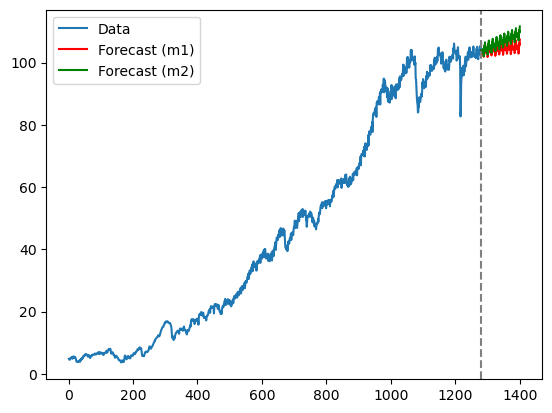

In [192]:
k = 120
n = len(y)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
fcast_1 = m1.get_prediction(start = n, end = n+k-1).predicted_mean
fcast_2 = m2.get_prediction(start = n, end = n+k-1).predicted_mean
plt.plot(tme, y, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Forecast (m1)', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Forecast (m2)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The two predictions above are close for future points that are near but diverge for farther points. 

Below we repeat the analysis with logarithms of the original data. 

In [193]:
import warnings
warnings.filterwarnings("ignore") #this suppresses convergence warnings. 


dt = np.log(y)
pmax, dmax, qmax = 2, 1, 2
Pmax, D, Qmax = 2, 1, 2
seasonal_period = 12

results = []

for p in range(pmax + 1):
    for d in range(dmax + 1):
        for q in range(qmax + 1):
            for P in range(Pmax + 1):
                for Q in range(Qmax + 1):
                    try:
                        model = ARIMA(dt, 
                                      order=(p, d, q), 
                                      seasonal_order=(P, D, Q, seasonal_period)).fit()
                        results.append({
                            'p': p, 'd': d, 'q': q,
                            'P': P, 'D': D, 'Q': Q,
                            'AIC': model.aic,
                            'BIC': model.bic
                        })
                    # Progress message
                        print(f"Successfully fit ARIMA({p},{d},{q})x({P},{D},{Q})")
                    except Exception as e:
                        print(f"ARIMA({p},{d},{q})x({P},{D},{Q}) failed: {e}")
                        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best models
best_aic_idx = results_df['AIC'].idxmin()
best_bic_idx = results_df['BIC'].idxmin()

best_aic_model = results_df.loc[best_aic_idx]
best_bic_model = results_df.loc[best_bic_idx]

# Display results
print("Best model by AIC:")
print(best_aic_model)

print("\nBest model by BIC:")
print(best_bic_model)

Successfully fit ARIMA(0,0,0)x(0,1,0)
Successfully fit ARIMA(0,0,0)x(0,1,1)
Successfully fit ARIMA(0,0,0)x(0,1,2)
Successfully fit ARIMA(0,0,0)x(1,1,0)
Successfully fit ARIMA(0,0,0)x(1,1,1)
Successfully fit ARIMA(0,0,0)x(1,1,2)
Successfully fit ARIMA(0,0,0)x(2,1,0)
Successfully fit ARIMA(0,0,0)x(2,1,1)
Successfully fit ARIMA(0,0,0)x(2,1,2)
Successfully fit ARIMA(0,0,1)x(0,1,0)
Successfully fit ARIMA(0,0,1)x(0,1,1)
Successfully fit ARIMA(0,0,1)x(0,1,2)
Successfully fit ARIMA(0,0,1)x(1,1,0)
Successfully fit ARIMA(0,0,1)x(1,1,1)
Successfully fit ARIMA(0,0,1)x(1,1,2)
Successfully fit ARIMA(0,0,1)x(2,1,0)
Successfully fit ARIMA(0,0,1)x(2,1,1)
Successfully fit ARIMA(0,0,1)x(2,1,2)
Successfully fit ARIMA(0,0,2)x(0,1,0)
Successfully fit ARIMA(0,0,2)x(0,1,1)
Successfully fit ARIMA(0,0,2)x(0,1,2)
Successfully fit ARIMA(0,0,2)x(1,1,0)
Successfully fit ARIMA(0,0,2)x(1,1,1)
Successfully fit ARIMA(0,0,2)x(1,1,2)
Successfully fit ARIMA(0,0,2)x(2,1,0)
Successfully fit ARIMA(0,0,2)x(2,1,1)
Successfully

Best AIC model is $ARIMA(1, 0, 2) \times (0, 1, 2)_{12}$ and best BIC model is $ARIMA(2, 0, 0) \times (0, 1, 1)_{12}$. 

In [194]:
m1log = ARIMA(np.log(y), order=(1,0,2), seasonal_order=(0,1,2,12)).fit()
print(m1log.summary())
m2log = ARIMA(np.log(y), order=(2,0,0), seasonal_order=(0,1,1,12)).fit()
print(m2log.summary())


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 1280
Model:             ARIMA(1, 0, 2)x(0, 1, 2, 12)   Log Likelihood                3107.158
Date:                          Thu, 20 Nov 2025   AIC                          -6202.316
Time:                                  23:29:16   BIC                          -6171.444
Sample:                                       0   HQIC                         -6190.718
                                         - 1280                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9801      0.005    191.027      0.000       0.970       0.990
ma.L1          0.4454      0.013     33.248      0.

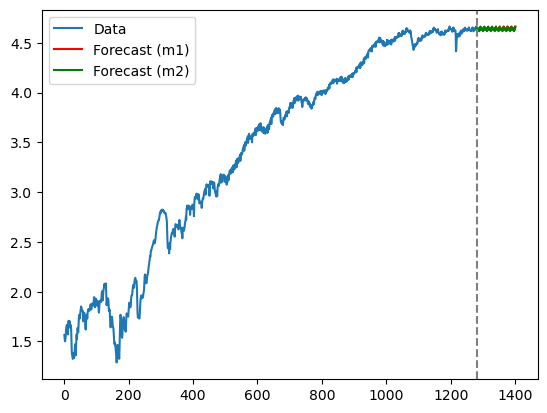

In [195]:
k = 120
n = len(y)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
fcast_1 = m1log.get_prediction(start = n, end = n+k-1).predicted_mean
fcast_2 = m2log.get_prediction(start = n, end = n+k-1).predicted_mean
plt.plot(tme, np.log(y), label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Forecast (m1)', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Forecast (m2)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

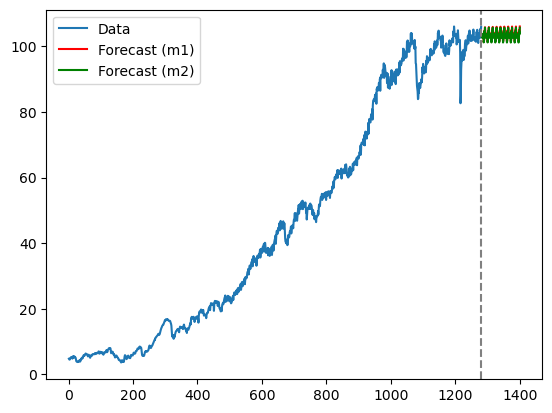

In [196]:
k = 120
n = len(y)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
fcast_1 = m1log.get_prediction(start = n, end = n+k-1).predicted_mean
fcast_2 = m2log.get_prediction(start = n, end = n+k-1).predicted_mean
plt.plot(tme, y, label = 'Data')
plt.plot(tme_future, np.exp(fcast_1), label = 'Forecast (m1)', color = 'red')
plt.plot(tme_future, np.exp(fcast_2), label = 'Forecast (m2)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The discrepancy between the predictions given by the best AIC and best BIC model differ significantly when the models are fitted first to the logarithms, than when the models are fitted for the original data. 